# Stance Detection on Tweets using NLP Methods

Note: This tutorial consists of two separate python notebooks. This is notebook is the second one. The first notebook can be found [here](TODO). I strongly recommend to read the first notebook first.

1. First notebook (this one): Fine-tuning BERT models: include standard BERT and domain-specific BERT
- TODO: add link

2. Second notebook: Promoting large language models (LLMs): include ChatGPT, FLAN-T5 and different prompt types (zero-shot, few-shot, chain-of-thought)
- TODO: add link


## Getting Started: Overview, Prerequisites, and Setup

**Objective of the tutorial**: This tutorial will guide you through the process of stance detection on tweets using two main approaches: fine-tuning a BERT model and using large language models (LLMs).

**Prerequisites**: 

- If you want to run the tutorial without editting the codes but want to understand the content
  - Basic Python skills: functions, classes, pandas, etc.
  - Basic ML knowledge: train-validation-test split, F1 score, forward pass, backpropagation etc.

- Familiarity with NLP concepts is a plus, particularly with transformers. However, if you're not familiar with them, don't worry. I'll provide brief explanations in the tutorial, as well as links to fantastic in-depth resources throughout the text.

**Acknowledgements**

- While the application of LLMs on stance detection is my own work, some part of this tutorials, e.g., GPT-3, are inspired by the following tutorials. Some of the figures are also modified from the images in these tutorials. I highly recommend you to check them out if you want to learn more about LLMs.
  - https://jalammar.github.io/illustrated-gpt2/#part-1-got-and-language-modeling
  - https://jalammar.github.io/how-gpt3-works-visualizations-animations/

**Setup**

TODO: should also navigate readers to select the GPU runtime

Download the content of this tutorial first by git clone

In [20]:
from os.path import join
ON_COLAB = False
if ON_COLAB:
  !git clone https://github.com/yunshiuan/prelim_stance_detection.git
  !python -m pip install pandas datasets openai accelerate transformers transformers[sentencepiece] torch==1.12.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html emoji -q
  %cd /content/prelim_stance_detection/scripts
else:
  %cd scripts

[Errno 2] No such file or directory: 'scripts'
/home/sean/prelim_stance_detection/scripts


In [21]:
# a helper function to load images in the notebook
from parameters_meta import ParametersMeta as par
PATH_IMAGES = join(par.PATH_ROOT, "images")
from PIL import Image as PILImage
from IPython.display import display
def display_resized_image_in_notebook(file_image, scale=1,use_default_path=True):
    """ Display an image in a notebook.
    """
    # - https://stackoverflow.com/questions/69654877/how-to-set-image-size-to-display-in-ipython-display
    # Open the image
    if use_default_path:
      file_image = join(PATH_IMAGES, file_image)
    image = PILImage.open(file_image)
    display(image.resize((int(image.width * scale), int(image.height * scale))))

****

## Two Stance Detection Paradigms

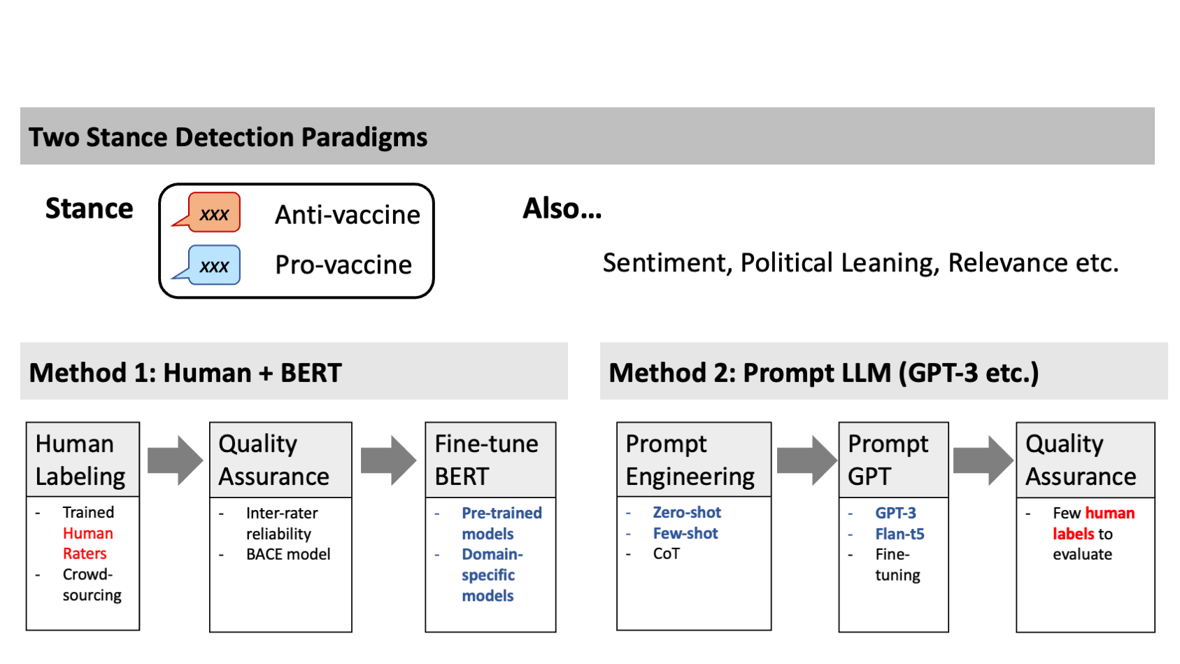

In [26]:
display_resized_image_in_notebook("stance_detection_two_paradigm.png", 0.7)

****

# Paradigm 2: Using Large Language Models (LLMs) for Stance Detection

Large Language Models (LLMs) like GPT-3 are gaining significant attention in recent years. These models are designed to understand and generate human-like text by learning from vast amounts of data. In the context of stance detection, LLMs can be used to classify text based on the stance towards a particular topic.


> Strictly speaking, BERT is also a type of LLMs. The "LLMs" covered in this notebook actually refer to a special type of LLMs, the "generative models", which means they can be used to generate text. In contrast, BERT is a discriminative model, which means it can only be used to classify text. I am using the term "LLMs" to refer to these generative models for the sake of simplicity.

Although there are many variants of LLMs, I will explain LLMs with GPT-3 as an example. Later in this tutorial, I will then point out the differences between GPT-3 and other LLMs, such as ChatGPT, FLAN-T5, etc.

## Contrast GPT-3 and BERT

### Model Architecture: Encoder vs. Decoder 

Both BERT and GPT-3 are transformer-based models, which means they both employ self-attention layers to learn the relationships between words in a text. However, they utilize self-attention layers differently.

Notably, in their model architecture, BERT uses "encoder blocks," while GPT-3 employs "decoder blocks." Due to this distinction, BERT is often referred to as an "encoder" model, while GPT-3 is commonly known as a "decoder" model.




<u>**Encoder (BERT)**</u>

In simple terms, an encoder model like BERT encodes an input sequence into a fixed-length vector (after 12 self-attention layers for BERT). This vector, or, representation, is then used to classify the input sequence.

Let's look at a concrete example from the Abortion dataset. 

> "<u>_It's so brilliant that #lovewins - now extend the equality to women's rights #abortionrights_</u>"


Recall from the previous tutorial that when an encoder model like BERT processes a sentence, it utilizes bidirectional context to accurately capture the meaning of the sentence. Afterward, we can fine-tune the model using a labeled dataset to adapt it to our specific task.

<u>**Decoder (GPT-3)**</u>

On the other hand, a decoder model like GPT-3 are designed to **generate** (rather than encode) a sequence from left to right, one token at a time. If we provide a partially complete sequence of words (also known as "prompt") to GPT-3, it will help complete the sequence (also known as "**conditional text generation**"). 

So, if we rephrase the same sentence into the following format, and provide GPT-3 with this partially complete sequece (also known is "**<u>prompt</u>**"), we can use GPT-3 to generate its prediction of the stance based on the prompt.

Let's rephrase the sentence into the following "**<u>prompt</u>**": 

> "What is the stance of the tweet below with respect to 'Legalization of Abortion'? Please use exactly one word from the following 3 categories to label it: 'in-favor', 'against', 'neutral-or-unclear'. Here is the tweet: '<u>_It's so brilliant that #lovewins - now extend the equality to women's rights #abortionrights_</u>.' The stance of the tweet is: "

With this rephrased sequence, we convert the stance detection task - a classification task, into a text generation task. We can then use GPT-3 to generate the stance of the tweet.

Note that GPT-3, like BERT, still uses self-attention layers to learn the relationships between words. The critical distinction is that when GPT-3 generates a sequence, it can only look at the words before the word to be generated (in this example, the prompt), rather than the bidirectional context like BERT. 

This difference in the usege of self-attention mechanism is shown in the following figure. On the left, we have the encoder model (BERT), where the self-attention layers are bidirectional, i.e., covering both the left and right context. 

On the right, we have the decoder model (GPT-3), where the self-attention layers are unidirectional, i.e., only covering the left context when evaluating the word to predict.

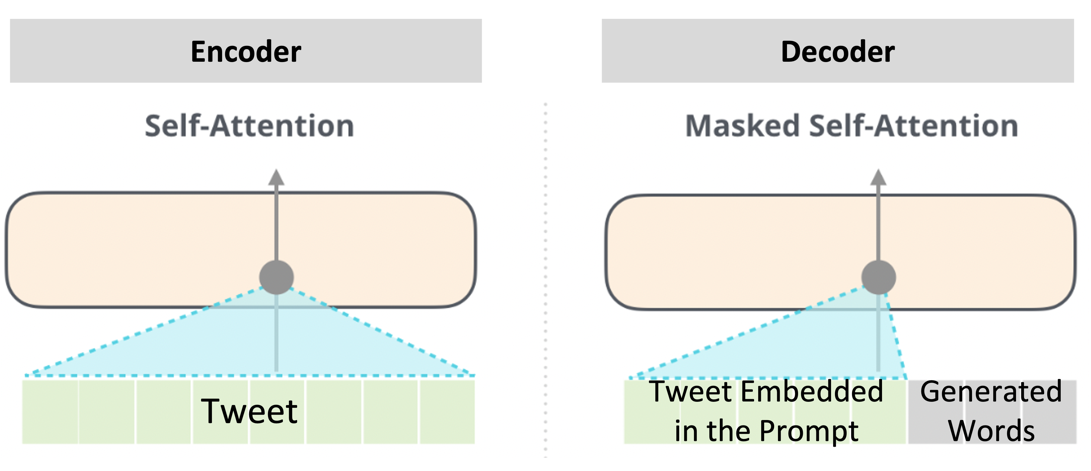

In [33]:
display_resized_image_in_notebook("encoder_vs_decoder.png",0.3)

> Another important difference between BERT and GPT-3 is the size of the context they can handle. BERT uses a context of 512 tokens, while GPT-3 can handle a much larger context depending on the specific model variant, with the largest version handling up to 4097 tokens. This means that GPT-3 can take into account a larger number of words when capturing the meaning of a word, which allows GPT-3 to consider more context surrounding a word and potentially leads to better understanding and generation capabilitie

### Model Size and Pre-Traing Data Size

While BERT is considered a Large Language Model, it has a much smaller number of parameters in the model, and has a smaller training data during the pre-training phase, compared to some of the more recent LLMs. Because of this constraint, BERT typically requires fine-tuning on a specific task, using a labeled dataset, to perform optimally.

Newer LLMs, like GPT-3 or Flan-T5, have been trained on even larger datasets and have demonstrated remarkable capabilities, including the ability to perform tasks with little or no fine-tuning. This is due to their extensive training, which allows them to generate more accurate and coherent responses in a variety of situations, including stance detection.


TODO: add a plot showing the difference in model size and pretraining corpus size

### Pre-training: Learning from Massive Amounts of Text

Like BERT model, LLMs also rely on pre-training to learn from massive amounts of text. During pre-training, LLMs are exposed to a large corpus of text, which allows them to learn the structure and style of human language. By learning from a diverse range of text sources, LLMs can build a rich understanding of language, including grammar, vocabulary, and context. This extensive knowledge can be particularly useful for detecting stances in text.


During training, LLMs optimize their parameters to minimize a loss function, which is a measure of the difference between the model's predictions and the actual target outputs. In the case of language models, the loss function is typically based on the likelihood of the correct next word (or token) given the context. By minimizing this loss function, the model learns to generate text that closely resembles the structure and style of the training data.

[TODO: add a diagram to show the loss function]

[TODO: add a table to illustrate the difference between BERT and LLMs]

### The role of fine-tuning

While BERT is designed to be fine-tuned on tasks of interest like stance detection using labeled data, some of these more recent LLMs can perform stance detection without further fine-tuning with labeled data. 

Note that LLMs still undergo fine-tuning (see below for details), but they are not fine-tuned on a specific task like stance detection. Instead, they are fine-tuned on a general language modeling task, which allows them to learn the structure and style of human language. This general pre-training allows them to perform well on a variety of tasks, including stance detection, without further fine-tuning.


#### The Potential of Prompting

While BERT is designed to be fine-tuned on specific tasks like stance detection using labeled data, some of these more recent LLMs can perform stance detection without fine-tuning, but with prompting techniques (i.e., the way you "ask" these models questions). These techniques involve providing the model with context or examples to guide its response, rather than relying on fine-tuning with labeled data.

For example, with a zero-shot approach, an LLM can perform stance detection on tweets without being fine-tuned on a specific dataset. The model can understand the task and generate an appropriate response based on its extensive knowledge learned during pretraining.

[TODO: add a diagram to illustrate different prompting techniques]

****

## Two state-of-the-art LLMs: ChatGPT-3.5 and FLAN-T5

Large Language Models (LLMs) have made significant advancements in the field of natural language processing in recent years. These models excel at understanding and generating human-like text by learning from vast amounts of data. Two notable LLMs that are frequently used for tasks such as stance detection are FLAN-T5 and OpenAI's ChatGPT-3.5.


### OpenAI's ChatGPT-3.5

OpenAI's ChatGPT-3.5 is a state-of-the-art language model, known for its impressive capabilities in understanding context and generating coherent text. Like BERT, it is also based on the Transformer architecture, but it has a much larger number of parameters and has been trained on a much larger dataset.

Due to the massive amount of training data, it perform well on various NLP tasks with little or no fine-tuning. ChatGPT-3.5's adaptability and powerful language processing make it a strong candidate for stance detection tasks.


#### How ChatGPT-3.5 is trained?

Its training process consists of two main steps: pre-training and fine-tuning.



##### Pre-training in ChatGPT-3.5

During the pre-training phase, ChatGPT-3.5 learns from vast amounts of text data gathered from various sources, such as websites, books, and articles. It is not explicitly trained on specific tasks at this stage; rather, it learns the structure, grammar, and general knowledge embedded in the text. The model's objective during pre-training is to predict the **next word** in a sentence, given the context of the words that come before it. This process, known as "language modeling," helps the model develop a deep understanding of language patterns and relationships.

https://jalammar.github.io/how-gpt3-works-visualizations-animations/

<img src="images/gpt3_training.gif">

##### Fine-tuning in ChatGPT-3.5

In the fine-tuning process of ChatGPT-3.5, **reinforcement learning from human feedback** (RLHF) plays a crucial role. This approach involves creating an initial dataset with human AI trainers (AI trainers providing conversations or responses to various prompts), generating comparison data by ranking multiple model-generated responses, building a reward model based on these rankings, and optimizing the ChatGPT-3.5 model using the reward model. Iteratively incorporating human feedback helps improve the model's performance, making it produce responses that are more similar to human responses.


![chatgpt3-5](images/chatgpt_diagram.svg)


### Open-source model FLAN-T5

The flan-T5 model is based on the T5 (Text-to-Text Transfer Transformer) architecture developed by Google Research. Like BERT and ChatGPT-3.5, flan-T5 is also built on the Transformer architecture. It is designed to handle a wide range of NLP tasks by converting them into a text-to-text format. The model's versatility and strong performance make it a popular choice for many short question-answering tasks, including stance detection.

TODO: add diagram to illustrate the T5 architecture

#### How is flan-T5 trained?


##### Pre-training in FLAN-T5

During the pre-training phase, FLAN-T5 undergoes a similar process to ChatGPT-3.5. Like ChatGPT3.5, it also learns from a large corpus of text data, which helps it develop a deep understanding of language patterns and relationships. The model's objective during pre-training is to predict the **next word** in a sentence, given the context of the words that come before it. This process, known as "language modeling," helps the model develop a deep understanding of language patterns and relationships.

##### Fine-tuning in flan-T5

For flan-T5, the fine-tuning process involves training the model on task-specific datasets. Unlike ChatGPT-3.5, which is focused on improving general conversational abilities, flan-T5 is designed to handle a wide range of NLP tasks by converting them into a text-to-text format. This means that flan-T5 is explicitly fine-tuned for various tasks like sentiment analysis, question answering, summarization, translation, and more.

During fine-tuning, flan-T5 learns to generate appropriate output text corresponding to the input text and the specific task it is being fine-tuned for. For example, if flan-T5 is being fine-tuned for translation, it might receive an input text in English and generate the corresponding translated text in another language, like French or German.

Some of the tasks that flan-T5 has been trained on include:

- Sentiment Analysis: Determining the sentiment or emotion expressed in a given text, such as identifying whether a movie review is positive, negative, or neutral.

- Named Entity Recognition (NER): Identifying and classifying entities such as names of people, organizations, locations, and dates within a text.

- Translation: Translating text from one language to another, for example, converting English text to French or German.

![flan-t5](images/flan_t5_xxl.png)

### Critical Distinctions between ChatGPT-3.5 and flan-T5

#### Propietary vs. Open-source

ChatGPT-3.5 is a proprietary model developed by OpenAI, and using it comes with costs, typically via API access. The implementation details and source code are not openly available, which limits users' ability to modify or understand the underlying workings of the model. On the other hand, flan-T5 is an open-source model, which means it is free to use, and the source code is publicly available for anyone to explore, use, and modify as needed. This distinction has implications for accessibility, transparency, and adaptability of the models for various tasks and research purposes.

#### Training Objectives 

ChatGPT-3.5 focuses on improving general conversational abilities and controllability, whereas flan-T5 is designed to handle a wide-range of short question-answering NLP tasks. Therefore, flan-T5 may not be as effective as ChatGPT-3.5 for tasks that requires a longer response, such as writing an essay.

#### Fine-tuning Data

ChatGPT-3.5 is fine-tuned on a narrower dataset with demonstrations and comparisons with human AI trainers, while flan-T5 is fine-tuned on task-specific datasets.

****


## Prompting Techniques for LLMs

To effectively utilize LLMs like flan-T5 and ChatGPT-3.5 for stance detection, we can employ various prompting techniques that guide the model's response without the need for fine-tuning. There are many different ways to prompt LLMs, and the choice of technique depends on the task at hand. In this section, we will discuss some of the most common prompting techniques.

> If you want to learn more about prompting techniques, I recommend this online tutorial: https://learnprompting.org/docs/intro


### Zero-shot Prompting

In the zero-shot prompting technique, the LLM is provided with a task description and a sample input without any specific examples. The model uses its pre-trained knowledge to understand the task and generate an appropriate response.

[TODO: add examples]


### Few-shot Prompting

The few-shot prompting technique involves providing the LLM with a small number of examples to guide its response. This allows the model to learn from the provided examples and adapt its output accordingly.

[TODO: add examples]


### Chain-of-thoughts Prompting

The chain-of-thoughts method involves breaking down a complex task into a series of simpler sub-tasks. The LLM generates intermediate outputs for each sub-task and uses these outputs as context to solve the overall problem.

[TODO: add examples]

****


## Programming Exercise: Implementing Stance Detection with flan-T5 and ChatGPT-3.5

Now, let's implement stance detection using FLAN-T5 and GPT 3.5.


# Preprocess Data

In [1]:
ON_COLAB = False
if ON_COLAB:
  !git clone https://github.com/yunshiuan/prelim_stance_detection.git
  !python -m pip install pandas datasets openai accelerate transformers transformers[sentencepiece] torch==1.12.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html emoji -q
  %cd /content/prelim_stance_detection/scripts
else:
  %cd scripts

/home/sean/prelim_stance_detection/scripts


In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from os.path import join

from data_processor import SemEvalDataProcessor
from utils import convert_time_unit_into_name, get_parameters_for_dataset, glob_re, list_full_paths, creat_dir_for_a_file_if_not_exists, check_if_item_exist_in_nested_list, get_dir_of_a_file,func_compute_metrics_sem_eval,partition_and_resample_df, process_dataframe, tidy_name


/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set up 
SEED = 42
TOPIC_OF_INTEREST = "Abortion"
DATASET = "SEM_EVAL"
par = get_parameters_for_dataset(DATASET)

PATH_OUTPUT_ROOT = join(par.PATH_RESULT_SEM_EVAL, "llm")

In [4]:

# preprocess the data
sem_eval_data = SemEvalDataProcessor()
sem_eval_data.preprocess()

df_processed = sem_eval_data._read_preprocessed_data(topic=TOPIC_OF_INTEREST).reset_index(drop=True)
# save the partitions (train, dev, test) for later use
df_partitions = sem_eval_data.partition_processed_data(seed=SEED,verbose=False)

# Create the Prompts

In [5]:
%load_ext autoreload
%autoreload 2
from gpt_data_processor import SemEvalGPTDataProcessor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Zero-shot prompt

In [6]:
# zero-shot (k = 0)
VERSION_PROMPT = "zero_shot"

In [7]:
gpt_data_processor = SemEvalGPTDataProcessor(version_prompt = VERSION_PROMPT, topic=TOPIC_OF_INTEREST)
# the prompt, which is the input to the LLMs
df_input_text = gpt_data_processor.embed_prompt(file_output=None, write_csv=False,
                                                return_df=True)

In [8]:
df_input_text.head()

,ID,tweet,topic,label,partition,tweet_embedded
0,2312,i really don't understand how some people are ...,Abortion,AGAINST,train,What is the stance of the tweet below with res...
1,2313,let's agree that it's not ok to kill a 7lbs ba...,Abortion,AGAINST,train,What is the stance of the tweet below with res...
2,2314,@USERNAME i would like to see poll: how many a...,Abortion,AGAINST,train,What is the stance of the tweet below with res...
3,2315,democrats are always against 'personhood' or w...,Abortion,AGAINST,train,What is the stance of the tweet below with res...
4,2316,@USERNAME 'if you don't draw the line where i'...,Abortion,NONE,train,What is the stance of the tweet below with res...


In [9]:
print("tweet:\n{}\n".format(df_input_text["tweet"][0]))
print("label:\n{}\n".format(df_input_text["label"][0]))

tweet:
i really don't understand how some people are pro-choice. a life is a life no matter if it's 2 weeks old or 20 years old.

label:
AGAINST



In [10]:
print("prompt:\n{}".format(df_input_text["tweet_embedded"][0]))

prompt:
What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Please use exactly one word from the following 3 categories to label it: 'in-favor', 'against', 'neutral-or-unclear'. Here is the tweet. 'i really don't understand how some people are pro-choice. a life is a life no matter if it's 2 weeks old or 20 years old.' The stance of the tweet is: 


## Few-shot prompt

In [11]:
gpt_data_processor = SemEvalGPTDataProcessor(version_prompt = "few_shot", topic=TOPIC_OF_INTEREST)
# the prompt, which is the input to the LLMs
df_input_text = gpt_data_processor.embed_prompt(file_output=None, write_csv=False,
                                                return_df=True)

In [12]:
print("tweet:\n{}\n".format(df_input_text["tweet"][0]))
print("label:\n{}\n".format(df_input_text["label"][0]))
print("prompt:\n{}".format(df_input_text["tweet_embedded"][0]))

tweet:
i really don't understand how some people are pro-choice. a life is a life no matter if it's 2 weeks old or 20 years old.

label:
AGAINST

prompt:
What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Please use exactly one word from the following 3 categories to label it: 'in-favor', 'against', 'neutral-or-unclear'.  Here are some examples of tweets. Make sure to classify the last tweet correctly.
Q: Tweet: it's a free country. f

## Chain-of-thought prompt (CoT)

In [13]:
gpt_data_processor = SemEvalGPTDataProcessor(version_prompt = "CoT", topic=TOPIC_OF_INTEREST)
# the prompt, which is the input to the LLMs
df_input_text = gpt_data_processor.embed_prompt(file_output=None, write_csv=False,
                                                return_df=True)

In [14]:
print("tweet:\n{}\n".format(df_input_text["tweet"][0]))
print("label:\n{}\n".format(df_input_text["label"][0]))
print("prompt:\n{}".format(df_input_text["tweet_embedded"][0]))

tweet:
i really don't understand how some people are pro-choice. a life is a life no matter if it's 2 weeks old or 20 years old.

label:
AGAINST

prompt:
What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Here is the tweet. 'i really don't understand how some people are pro-choice. a life is a life no matter if it's 2 weeks old or 20 years old.' What is the stance of the tweet with respect to 'Legalization of Abortion'? Please make su

# Feed the prompts to FLAN-T5 models

In [15]:
%load_ext autoreload
%autoreload 2
from gpt_predict_label import FlanT5LargeLabelPredictor, FlanT5XxlLabelPredictor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helpfer function

In [16]:
def prompt_flan_t5(model_type, prompt_version):
    # get the output paths
    # model_type_name = tidy_name(model_type)
    path_output = join(PATH_OUTPUT_ROOT, model_type, prompt_version)
    file_output_predictions = join(path_output, "predictions.csv")

    gpt_data_processor = SemEvalGPTDataProcessor(version_prompt=prompt_version, topic=TOPIC_OF_INTEREST)
    
    # create the prompt, which is the input to the LLMs
    df_input_text = gpt_data_processor.embed_prompt(file_output=None, write_csv=False,
                                                    return_df=True)

    # partition the data into train, vali, test (note that we only need the vali and test set in this approach)
    dict_df_single_domain = partition_and_resample_df(
        df_input_text, seed=None, partition_type="single_domain",
        read_partition_from_df=True,
        df_partitions=df_partitions)

    # select the partition to be labeled
    # - vali and test
    df_input_text_filtered = pd.DataFrame()
    for partition in ["vali_raw", "test_raw"]:
        df_input_text_filtered = pd.concat([df_input_text_filtered, dict_df_single_domain[partition]])

    df_input_text = df_input_text_filtered

    # specify the output type (single-word or multi-word)
    if prompt_version in ["zero_shot","few_shot"]:
        mode_output = "single-word"
    elif prompt_version == "CoT":
        mode_output = "CoT"

    if model_type == "flan-t5-large":
        llm_label_predictor = FlanT5LargeLabelPredictor(col_name_text="tweet_embedded",
                                                        col_name_label="stance_predicted",
                                                        col_name_text_id=par.TEXT_ID,
                                                        try_use_gpu=True,
                                                        per_device_eval_batch_size=16,
                                                        mode_output=mode_output,
                                                        for_generation_only=True)
    elif model_type == "flan-t5-xxl":
        llm_label_predictor = FlanT5XxlLabelPredictor(col_name_text="tweet_embedded",
                                                        col_name_label="stance_predicted",
                                                        col_name_text_id=par.TEXT_ID,
                                                        try_use_gpu=True,
                                                        per_device_eval_batch_size=16,
                                                        mode_output=mode_output,
                                                        for_generation_only=True)        
    else:
        raise ValueError("model_type not supported")

    # prompt the LLM to make predictions (write the predictions to `file_output_predictions`)
    llm_label_predictor.predict_labels(df_input_text,
                                       file_output_predictions,
                                       keep_tweet_id=True, keep_text=False,
                                       output_prob_mode=None,
                                       list_label_space=None,
                                       col_name_tweet_id=par.TEXT_ID)


## Prompt the FLAN-T5 models with 2 different prompts

In [17]:
model_type = "flan-t5-large"
for prompt_version in ["zero_shot","few_shot"]:
    print("model:{}, prompt version: {}".format(model_type, prompt_version))
    # prompt_flan_t5(model_type, prompt_version)

model:flan-t5-large, prompt version: zero_shot
model:flan-t5-large, prompt version: few_shot


In [18]:
# run this only if use you a large enough GPU (>30GB)
LARGE_GPU_AVAILABLE = False
if LARGE_GPU_AVAILABLE:
    model_type = "flan-t5-xxl"
    for prompt_version in ["zero_shot","few_shot"]:
        print("model:{}, prompt version: {}".format(model_type, prompt_version))
        prompt_flan_t5(model_type, prompt_version)

### View the predictions

In [19]:
path_model_output =  join(PATH_OUTPUT_ROOT, model_type, "zero_shot")
file_input_predictions = join(path_model_output,"predictions.csv")
df_predictions = pd.read_csv(file_input_predictions)

In [20]:
df_predictions.head()

,stance_predicted,ID,tweet_embedded
0,in-favor,2313,What is the stance of the tweet below with res...
1,in-favor,2316,What is the stance of the tweet below with res...
2,in-favor,2317,What is the stance of the tweet below with res...
3,against,2323,What is the stance of the tweet below with res...
4,in-favor,2331,What is the stance of the tweet below with res...


## Evaluate the Predictions of Different Prompts and Different Models

In [21]:
from gpt_evaluate_labels import SemEvalGPTLabelEvaluator
from result_summarizer import ResultSummarizer

In [22]:
def evaluate(model_type, prompt_version):
    gpt_data_processor = SemEvalGPTDataProcessor(topic=TOPIC_OF_INTEREST,
                                                version_prompt=prompt_version)
    data_processor = SemEvalDataProcessor()

    # get the data with ground-truth labels and partition information (only evaluate on the vali and test set)
    file_ground_truth = data_processor._get_file_processed_default(topic=TOPIC_OF_INTEREST)
    df = process_dataframe(
        input_csv=file_ground_truth,
        dataset=DATASET)
    df_partitions = data_processor.read_partitions(topic=TOPIC_OF_INTEREST)
    dict_df_single_domain = partition_and_resample_df(
        df, seed=None, partition_type="single_domain",
        read_partition_from_df=True,
        df_partitions=df_partitions)
    del dict_df_single_domain["train_raw"]


    # set the output path
    path_model_output =  join(PATH_OUTPUT_ROOT, model_type, prompt_version)
    file_output_metrics = join(path_model_output,"metrics.csv")
    file_output_confusion_mat = join(path_model_output,"confusion_matrix.csv")
    # also get the predictions
    file_input_predictions = join(path_model_output,"predictions.csv")

    # evaluate the predictions
    gpt_label_evaluator = SemEvalGPTLabelEvaluator(
        file_input_predictions=file_input_predictions,
        file_input_ground_truth=file_ground_truth,
        topic=TOPIC_OF_INTEREST, dataset=DATASET,
        model_gpt=model_type,
        num_examples_in_prompt=gpt_data_processor._get_num_examples_in_prompt(),
        key_join="ID",
        list_tweet_id_in_prompt=gpt_data_processor._get_list_tweet_id_in_prompt(),
        full_predictions=False)
    gpt_label_evaluator.evaluate(
        file_output_metrics=file_output_metrics,
        file_output_confusion_mat=file_output_confusion_mat,
        dict_df_eval=dict_df_single_domain,
        col_name_set="set")    

In [23]:
evaluate("flan-t5-large", "zero_shot")
evaluate("flan-t5-large", "few_shot")
# although you may not have run the xxl model due to GPU contraint, you can still evaluate the results because I have already run the model elsewhere and saved the predictions
evaluate("flan-t5-xxl", "zero_shot")
evaluate("flan-t5-xxl", "few_shot")

/home/sean/prelim_stance_detection/scripts/utils.py:713: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_computer[name_metric] = load_metric(name_metric)


In [24]:
def summarize_results(list_model_type, list_prompt_version):
    df_hightlight_metrics = pd.DataFrame()
    for model_type in list_model_type:
        # summarize the results
        result_summarizer = ResultSummarizer(dataset=DATASET,
                                             list_version_output=list_prompt_version,
                                             eval_mode="single_domain",
                                             model_type="llm_" + model_type,
                                             task=None,
                                             file_name_metrics="metrics.csv",
                                             file_name_confusion_mat="confusion_matrix.csv",
                                             path_input_root=join(PATH_OUTPUT_ROOT, model_type),
                                             path_output=join(PATH_OUTPUT_ROOT,"summary"))
        # write the summary to a csv file
        df_hightlight_metrics_this = result_summarizer.write_hightlight_metrics_to_summary_csv(
            list_metrics_highlight=['f1_macro', 'f1_NONE', 'f1_FAVOR', 'f1_AGAINST'],
            list_sets_highlight=['vali_raw', 'test_raw'],
            col_name_set="set")
        # visualize the confusion matrices and save the figures
        result_summarizer.visualize_confusion_metrices_over_domains_comb(
            ["vali_raw", "test_raw"],
            preserve_order_list_sets=True)

        df_hightlight_metrics = pd.concat([df_hightlight_metrics, df_hightlight_metrics_this], axis=0)
    return df_hightlight_metrics


In [25]:
# sumamrize the result acrpss different models and prompt versions
# - also visualize the confusion matrices
df_hightlight_metrics_flan_t5 = summarize_results(["flan-t5-large","flan-t5-xxl"],["zero_shot","few_shot"])

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [26]:
df_hightlight_metrics_flan_t5 = df_hightlight_metrics_flan_t5[df_hightlight_metrics_flan_t5.model_type.isin(["llm_flan-t5-large","llm_flan-t5-xxl"])]

In [27]:

# reorder the rows
df_hightlight_metrics_flan_t5['model_type'] = pd.Categorical(df_hightlight_metrics_flan_t5['model_type'], categories=["llm_flan-t5-large","llm_flan-t5-xxl"], ordered=True)
df_hightlight_metrics_flan_t5['version'] = pd.Categorical(df_hightlight_metrics_flan_t5['version'], categories=["zero_shot","few_shot"], ordered=True)
df_hightlight_metrics_flan_t5 = df_hightlight_metrics_flan_t5.sort_values(by=["model_type","version"]).reset_index(drop=True)

In [28]:
df_hightlight_metrics_flan_t5 = df_hightlight_metrics_flan_t5[["model_type","version","set","f1_macro","f1_NONE","f1_FAVOR","f1_AGAINST"]][df_hightlight_metrics_flan_t5.set.isin(["test_raw"])].sort_values(by=["model_type","version"])
df_hightlight_metrics_flan_t5

,model_type,version,set,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
1,llm_flan-t5-large,zero_shot,test_raw,0.2129,0.0435,0.1810,0.4143
3,llm_flan-t5-large,zero_shot,test_raw,0.2129,0.0435,0.1810,0.4143
5,llm_flan-t5-large,few_shot,test_raw,0.2780,0.0833,0.1990,0.5517
7,llm_flan-t5-large,few_shot,test_raw,0.2780,0.0833,0.1990,0.5517
9,llm_flan-t5-xxl,zero_shot,test_raw,0.6190,0.5833,0.5312,0.7425
11,llm_flan-t5-xxl,zero_shot,test_raw,0.6190,0.5833,0.5312,0.7425
13,llm_flan-t5-xxl,few_shot,test_raw,0.5919,0.5347,0.5197,0.7212
15,llm_flan-t5-xxl,few_shot,test_raw,0.5919,0.5347,0.5197,0.7212


### Compare FLAN-T5 with BERT

- from the previous tutorial

In [29]:
df_hightlight_metrics_bert = pd.read_csv(join(par.PATH_RESULT_SEM_EVAL_TUNING,"summary","metrics_highlights.csv"))
df_hightlight_metrics_bert = df_hightlight_metrics_bert[["version","set","f1_macro","f1_NONE","f1_FAVOR","f1_AGAINST"]][df_hightlight_metrics_bert.set.isin(["test_raw"])].rename(columns={"version":"model_type"})
# reorder the rows
df_hightlight_metrics_bert['model_type'] = pd.Categorical(df_hightlight_metrics_bert['model_type'], categories=["bert-base-uncased","vinai_bertweet_base","kornosk_polibertweet_mlm"], ordered=True)
df_hightlight_metrics_bert = df_hightlight_metrics_bert.sort_values(by=["model_type"]).reset_index(drop=True)
df_hightlight_metrics_bert

,model_type,set,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
0,bert-base-uncased,test_raw,0.4549,0.4060,0.4056,0.5532
1,vinai_bertweet_base,test_raw,0.4933,0.4507,0.4741,0.5552
2,kornosk_polibertweet_mlm,test_raw,0.5200,0.4848,0.4697,0.6054


# Feed the prompts to ChatGPT
- ChatGPT-turbo-3.5

In [30]:
# Whether you want to prompt the GPT model yourself (this would cost around $1 USD for the entire tutorial)
PROMPT_CHAT_GPT = False

# You should set the API key for OpenAI
OPEN_AI_KEY = "FILL YOUR KEY HERE"

if PROMPT_CHAT_GPT:
    assert OPEN_AI_KEY!="FILL YOUR KEY HERE", "You should set the API key for OpenAI"

In [31]:
from gpt_predict_label import GPTChatTurbo3_5LabelPredictor

In [32]:
class PromptChatGPT_3_5:
    def __init__(self,prompt_version) -> None:
        # get the output paths
        # model_type_name = tidy_name(model_type)
        path_output = join(PATH_OUTPUT_ROOT, "chatgpt_turbo_3_5", prompt_version)
        self.file_output_predictions = join(path_output, "predictions.csv")

        gpt_data_processor = SemEvalGPTDataProcessor(version_prompt=prompt_version, topic=TOPIC_OF_INTEREST)
        
        # create the prompt, which is the input to the LLMs
        df_input_text = gpt_data_processor.embed_prompt(file_output=None, write_csv=False,
                                                        return_df=True)

        # partition the data into train, vali, test (note that we only need the vali and test set in this approach)
        dict_df_single_domain = partition_and_resample_df(
            df_input_text, seed=None, partition_type="single_domain",
            read_partition_from_df=True,
            df_partitions=df_partitions)

        # select the partition to be labeled
        # - vali and test
        df_input_text_filtered = pd.DataFrame()
        for partition in ["vali_raw", "test_raw"]:
            df_input_text_filtered = pd.concat([df_input_text_filtered, dict_df_single_domain[partition]])

        self.df_input_text = df_input_text_filtered

        # specify the output type (single-word or multi-word)
        if prompt_version in ["zero_shot","few_shot"]:
            mode_output = "single-word"
        elif prompt_version == "CoT":
            mode_output = "CoT"

        self.llm_label_predictor = GPTChatTurbo3_5LabelPredictor(col_name_text="tweet_embedded",
                                                            col_name_label="stance_predicted",
                                                            col_name_text_id=par.TEXT_ID,
                                                            mode_output=mode_output)
    def estimate_cost(self):
        total_cost_estimate = self.llm_label_predictor.estimate_total_cost(self.df_input_text)
        print("Estimated total cost: ${}".format(total_cost_estimate))        
    def predict_labels(self):
        # prompt the LLM to make predictions (write the predictions to `file_output_predictions`)
        self.llm_label_predictor.predict_labels(self.df_input_text,
                                           self.file_output_predictions,
                                           keep_tweet_id=True, keep_text=False,
                                           output_prob_mode=None,
                                           list_label_space=None,
                                           col_name_tweet_id=par.TEXT_ID)
    def load_predicted_labels(self):
        # load the predictions
        df_predictions = pd.read_csv(self.file_output_predictions)
        return df_predictions


In [33]:
prompt_chat_gpt_zero_shot = PromptChatGPT_3_5("zero_shot")


In [34]:
prompt_chat_gpt_zero_shot.estimate_cost()

Estimated total cost: $0.19196200000000002


In [35]:
if PROMPT_CHAT_GPT:
  prompt_chat_gpt_zero_shot.predict_labels()

In [36]:
prompt_chat_gpt_few_shot = PromptChatGPT_3_5("few_shot")
prompt_chat_gpt_few_shot.estimate_cost()
if PROMPT_CHAT_GPT:
  prompt_chat_gpt_few_shot.predict_labels()

Estimated total cost: $0.3164880000000003


In [37]:
prompt_chat_gpt_cot = PromptChatGPT_3_5("CoT")
prompt_chat_gpt_cot.estimate_cost()
if PROMPT_CHAT_GPT:
  prompt_chat_gpt_cot.predict_labels()

Estimated total cost: $0.3324100000000002


## View the predictions

In [38]:
TEXT_ID_EXAMPLE = 9

In [39]:

print("prompt:\n {}\n".format(prompt_chat_gpt_zero_shot.load_predicted_labels().loc[TEXT_ID_EXAMPLE,"tweet_embedded"]))
print("GPT response:\n {}\n".format(prompt_chat_gpt_zero_shot.load_predicted_labels().loc[TEXT_ID_EXAMPLE,"stance_predicted"]))

prompt:
 What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Please use exactly one word from the following 3 categories to label it: 'in-favor', 'against', 'neutral-or-unclear'. Here is the tweet. 'dear religious right: i keep my uterus out of your church, so keep your church out my uterus.' The stance of the tweet is: 

GPT response:
 in-favor.



In [40]:
print("prompt:\n {}\n".format(prompt_chat_gpt_few_shot.load_predicted_labels().loc[TEXT_ID_EXAMPLE,"tweet_embedded"]))
print("GPT response:\n {}\n".format(prompt_chat_gpt_few_shot.load_predicted_labels().loc[TEXT_ID_EXAMPLE,"stance_predicted"]))

prompt:
 What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Please use exactly one word from the following 3 categories to label it: 'in-favor', 'against', 'neutral-or-unclear'.  Here are some examples of tweets. Make sure to classify the last tweet correctly.
Q: Tweet: it's a free country. freedom includes freedom of choice.
Is this tweet in-favor, against, or neutral-or-unclear?
A: in-favor
Q: Tweet: i really don't understand how so

In [41]:
print("prompt:\n {}\n".format(prompt_chat_gpt_cot.load_predicted_labels().loc[TEXT_ID_EXAMPLE,"tweet_embedded"]))
print("GPT response:\n {}\n".format(prompt_chat_gpt_cot.load_predicted_labels().loc[TEXT_ID_EXAMPLE,"stance_predicted"]))

prompt:
 What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Here is the tweet. 'dear religious right: i keep my uterus out of your church, so keep your church out my uterus.' What is the stance of the tweet with respect to 'Legalization of Abortion'? Please make sure that at the end of your response, use exactly one word from the following 3 categories to label the stance with respect to 'Legalization of Abortion': 'in-favor', 'agains

## Evaluate the Predictions of Different Prompts

In [42]:
evaluate("chatgpt_turbo_3_5", "zero_shot")
evaluate("chatgpt_turbo_3_5", "few_shot")
evaluate("chatgpt_turbo_3_5", "CoT")

In [43]:
df_hightlight_metrics_chatgpt = summarize_results(["chatgpt_turbo_3_5"], ["zero_shot","few_shot","CoT"])

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [44]:
df_hightlight_metrics_chatgpt = df_hightlight_metrics_chatgpt[df_hightlight_metrics_chatgpt.model_type.isin(["llm_chatgpt_turbo_3_5"])]

# reorder the rows
df_hightlight_metrics_chatgpt['model_type'] = pd.Categorical(df_hightlight_metrics_chatgpt['model_type'], categories=["llm_chatgpt_turbo_3_5"], ordered=True)
df_hightlight_metrics_chatgpt['version'] = pd.Categorical(df_hightlight_metrics_chatgpt['version'], categories=["zero_shot","few_shot","CoT"], ordered=True)

df_hightlight_metrics_chatgpt = df_hightlight_metrics_chatgpt[["model_type","version","set","f1_macro","f1_NONE","f1_FAVOR","f1_AGAINST"]][df_hightlight_metrics_chatgpt.set.isin(["test_raw"])].sort_values(by=["model_type","version"])
df_hightlight_metrics_chatgpt

,model_type,version,set,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
15,llm_chatgpt_turbo_3_5,zero_shot,test_raw,0.5071,0.4356,0.6723,0.4135
17,llm_chatgpt_turbo_3_5,few_shot,test_raw,0.6372,0.5634,0.6769,0.6713
19,llm_chatgpt_turbo_3_5,CoT,test_raw,0.3877,0.3600,0.5684,0.2347


## Look at the confusion matrix

In [45]:
from IPython.display import Image, display

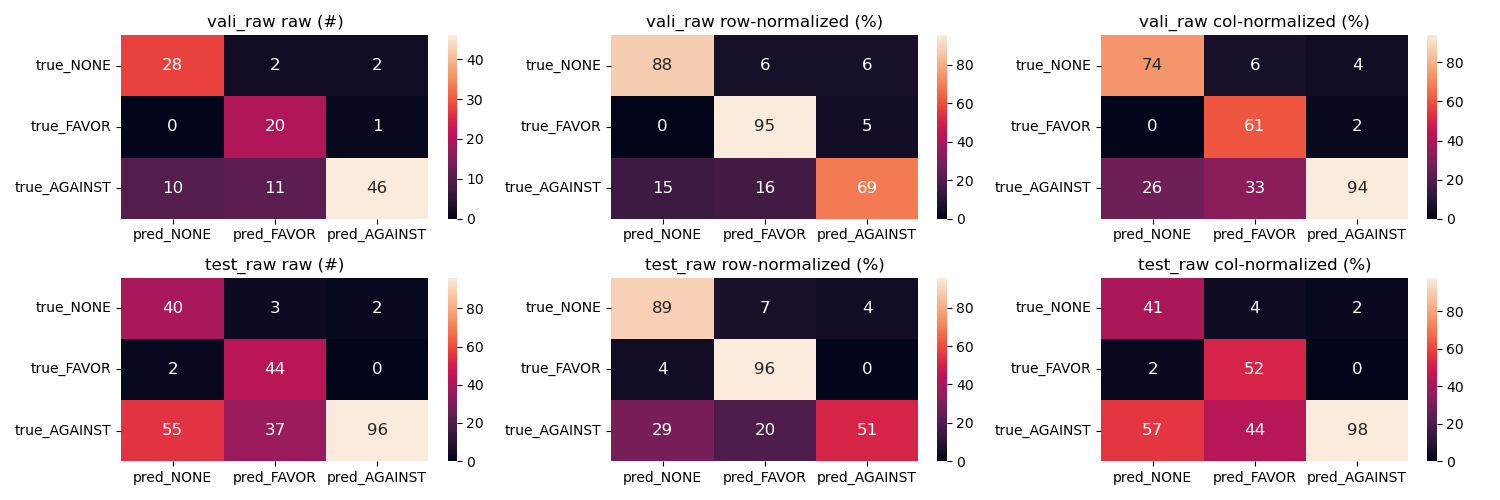

In [47]:
# read png file
display(Image(filename=join(PATH_OUTPUT_ROOT,"summary","chatgpt_turbo_3_5_few_shot_comb_confusion_mat.png")))

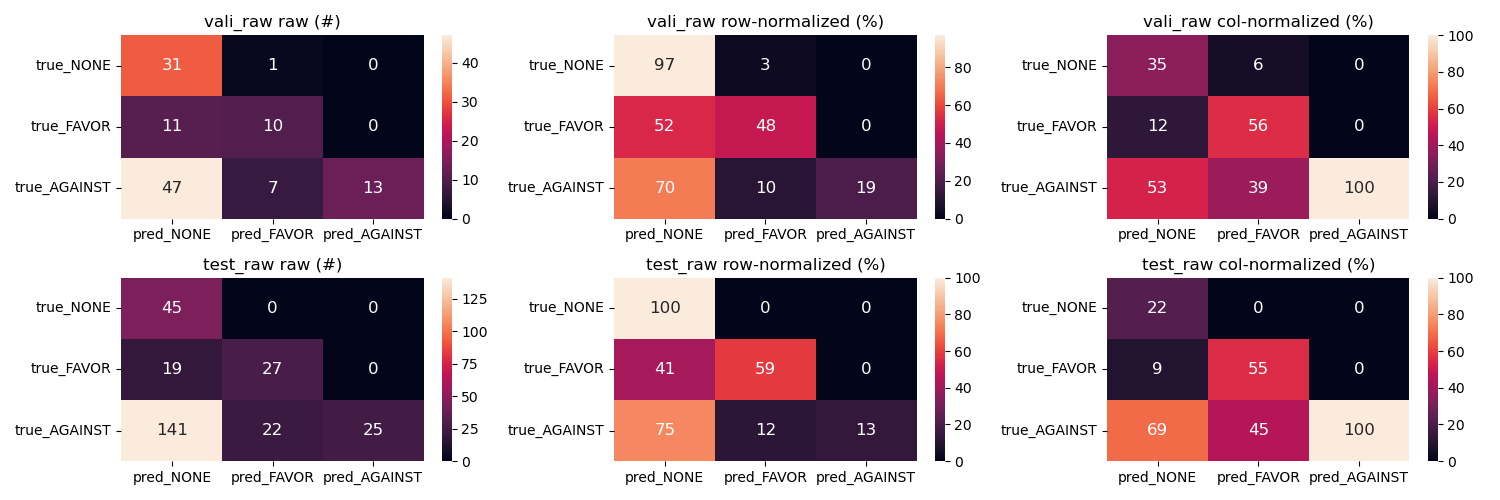

In [48]:
display(Image(filename=join(PATH_OUTPUT_ROOT,"summary","chatgpt_turbo_3_5_CoT_comb_confusion_mat.png")))


# Compare ChatGPT with FLAN-T5 and BERT

In [49]:
df_hightlight_metrics_llm = \
  pd.concat([df_hightlight_metrics_flan_t5 , df_hightlight_metrics_chatgpt],
           axis=0)
# order the columns: model_type, version, set, f1_macro, f1_NONE, f1_FAVOR, f1_AGAINST
df_hightlight_metrics_llm = df_hightlight_metrics_llm[["model_type","version","set","f1_macro","f1_NONE","f1_FAVOR","f1_AGAINST"]]
df_hightlight_metrics_llm

,model_type,version,set,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
1,llm_flan-t5-large,zero_shot,test_raw,0.2129,0.0435,0.1810,0.4143
3,llm_flan-t5-large,zero_shot,test_raw,0.2129,0.0435,0.1810,0.4143
5,llm_flan-t5-large,few_shot,test_raw,0.2780,0.0833,0.1990,0.5517
7,llm_flan-t5-large,few_shot,test_raw,0.2780,0.0833,0.1990,0.5517
9,llm_flan-t5-xxl,zero_shot,test_raw,0.6190,0.5833,0.5312,0.7425
11,llm_flan-t5-xxl,zero_shot,test_raw,0.6190,0.5833,0.5312,0.7425
13,llm_flan-t5-xxl,few_shot,test_raw,0.5919,0.5347,0.5197,0.7212
15,llm_flan-t5-xxl,few_shot,test_raw,0.5919,0.5347,0.5197,0.7212
15,llm_chatgpt_turbo_3_5,zero_shot,test_raw,0.5071,0.4356,0.6723,0.4135
17,llm_chatgpt_turbo_3_5,few_shot,test_raw,0.6372,0.5634,0.6769,0.6713


In [50]:
# bert
df_hightlight_metrics_bert

,model_type,set,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
0,bert-base-uncased,test_raw,0.4549,0.4060,0.4056,0.5532
1,vinai_bertweet_base,test_raw,0.4933,0.4507,0.4741,0.5552
2,kornosk_polibertweet_mlm,test_raw,0.5200,0.4848,0.4697,0.6054
